# Homework 3

## Problem 1

Read the data.

In [1]:
import pandas as pd

df = pd.read_csv('caesarian_data.txt', delimiter=' ', names=('age', 'num', 'tim', 'pre', 'hrt', 'cae'))

Get relevant arrays, normalize them, and split into testing and training data.

In [205]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

y = df['cae']
x = MinMaxScaler().fit_transform(df[['age', 'num', 'hrt']])

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

### (a)

Do logistic regression (using the training split) on `age`, `num` and `hrt` to predict `cae`.

In [206]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', C=1.).fit(x_train, y_train)
print(
    f'Model parameters: '
    f'theta_age = {model.coef_[0, 0]:.03g}, '
    f'theta_num = {model.coef_[0, 1]:.03g}, '
    f'theta_hrt = {model.coef_[0, 2]:.03g}, '
    f'theta_0 = {model.intercept_[0]:.03g}'
)

Model parameters: theta_age = 0.19, theta_num = 0.714, theta_hrt = 1.26, theta_0 = -0.51


### (b)

Calculate confusion matrix and accuracy for both training and testing splits.

In [207]:
from sklearn.metrics import confusion_matrix, accuracy_score

for x_split, y_split, split in [(x_train, y_train, 'train'), (x_test, y_test, 'test')]:
    print(f'Metrics for split {split}')
    print('Confusion matrix')
    y_split_pred = model.predict(x_split)
    print(confusion_matrix(y_split, y_split_pred))
    print('Accuracy')
    print(f'{100 * accuracy_score(y_split, y_split_pred):.01f}%')
    print()

Metrics for split train
Confusion matrix
[[23  6]
 [12 23]]
Accuracy
71.9%

Metrics for split test
Confusion matrix
[[4 1]
 [6 5]]
Accuracy
56.2%



### (c)

Abstract the above code for training.

In [231]:
class TestLogisticRegression:
    def __init__(self, x, y, l2_coef):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, train_size=0.8)
        self.model = LogisticRegression(penalty='l2', C=l2_coef).fit(self.x_train, self.y_train)
        self.y_train_pred = self.model.predict(self.x_train)
        self.y_test_pred = self.model.predict(self.x_test)
    
    def metric(self, split, metric):
        if split == 'train':
            return metric(self.y_train, self.y_train_pred)
        else:
            return metric(self.y_test, self.y_test_pred)

Now we can run many regressions with different coefficients on the regularization term.

In [239]:
import numpy as np

coefs = np.exp(np.linspace(-4, 5, 50))
avg_train_accuracies, avg_test_accuracies = [], []
num_splits = 200

for i, l2_coef in enumerate(coefs):
    total_train_acc, total_test_acc = 0, 0
    
    for _ in range(num_splits):
        test = TestLogisticRegression(x, y, l2_coef)
        total_train_acc += test.metric('train', accuracy_score)
        total_test_acc += test.metric('test', accuracy_score)

    avg_train_accuracies.append(total_train_acc / num_splits)
    avg_test_accuracies.append(total_test_acc / num_splits)
    print(f'Progress: {(i + 1) / len(coefs) * 100:.01f}%     ', end='\r')
print('Finished                 ')

Finished                 


Now let's see how the average train and test accuracies depend on the penalty coefficients.

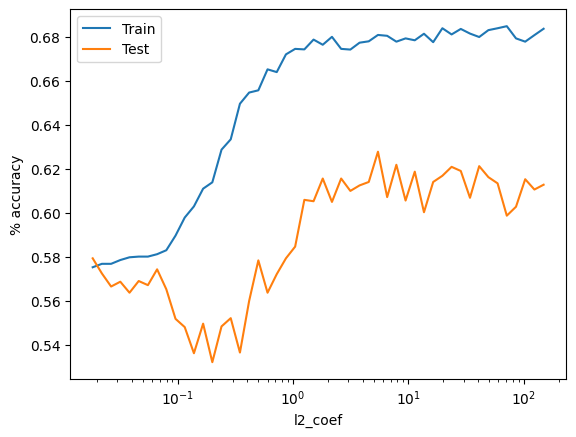

In [240]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(coefs, avg_train_accuracies, label='Train')
ax.plot(coefs, avg_test_accuracies, label='Test')

ax.set_xlabel('l2_coef')
ax.set_ylabel('% accuracy')
ax.legend()

plt.show()

Noting that the lower $\small\verb*|l2_coef|$ means a stronger regularization (because `sklearn` uses $\frac{1}{\small\verb*|l2_coef|}$ as the coefficient of the regularization term), we see that the regularization degrades the accuracy of the model if it is too strong (the downward trend in accuracy as $\small\verb*|l2_coef| \to 0$) and has no effect if it is too weak (accuracy flattens out as $\small\verb*|l2_coef|\to \infty$). 

There does seem to be a value of $\small\verb*|l2_coef|$ a little less than $10^1$ for which the test accuracy is maximal, but only greater than the accuracy with no regularization (that is, the accuracy as $\small\verb*|l2_coef|\to\infty$).

The training accuracy, on the other hand, seems to only increase as the regularization is reduced.

Lastly, there is strong drop in accuaracy when $\small\verb*|l2_coef|$ drops below $\sim 10^0$.

### (d)

Set the classification threshold to 0.6 on our original model, and see how the perfmance changes. First, recall the previous result.

In [241]:
for x_split, y_split, split in [(x_train, y_train, 'train'), (x_test, y_test, 'test')]:
    print(f'Metrics for split {split}')
    print('Confusion matrix')
    y_split_pred = model.predict(x_split)
    print(confusion_matrix(y_split, y_split_pred))
    print('Accuracy')
    print(f'{100 * accuracy_score(y_split, y_split_pred):.01f}%')
    print()

Metrics for split train
Confusion matrix
[[23  6]
 [12 23]]
Accuracy
71.9%

Metrics for split test
Confusion matrix
[[4 1]
 [6 5]]
Accuracy
56.2%



Now raise the threshold to 0.6 and see what we get.

In [246]:
for x_split, y_split, split in [(x_train, y_train, 'train'), (x_test, y_test, 'test')]:
    print(f'Metrics for split {split}')
    print('Confusion matrix')
    y_split_pred = (model.predict_proba(x_split)[:, 1] > 0.6).astype(int)
    print(confusion_matrix(y_split, y_split_pred))
    print('Accuracy')
    print(f'{100 * accuracy_score(y_split, y_split_pred):.01f}%')
    print()

Metrics for split train
Confusion matrix
[[24  5]
 [16 19]]
Accuracy
67.2%

Metrics for split test
Confusion matrix
[[4 1]
 [6 5]]
Accuracy
56.2%



The accuracy decreased, but the number of false positives (top right entry of the confusion matrix) also decreased, as did the number of true positives (bottom right entry of confusion matrix).

## Problem 2

Load the data, get the needed features, normalize, and create training and testing splits.

In [286]:
df = pd.read_csv('iris.csv')

species_index = {species: index for index, species in enumerate(np.unique(df['species']))}
y2 = df['species'].apply(lambda species: species_index[species])
x2 = df[['petal_length', 'petal_width']]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, train_size=.8)

### (a) and (b)

Create the models

In [287]:
one_vs_rest_model = LogisticRegression(multi_class='ovr').fit(x_train2, y_train2)
softmax_model = LogisticRegression(multi_class='multinomial').fit(x_train2, y_train2)

Display accuracy and confusion matrices for train and test splits for each model.

In [288]:
print('-----------------------------------------\n')
for test_model, test_model_type in ((one_vs_rest_model, 'One vs. Rest'), (softmax_model, 'Softmax')):
    print(f'Metrics for model type {test_model_type}')
    for x_split, y_split, split in [(x_train2, y_train2, 'train'), (x_test2, y_test2, 'test')]:
        print(f'Metrics for split {split}')
        print('Confusion matrix')
        y_split_pred = test_model.predict(x_split)
        print(confusion_matrix(y_split, y_split_pred))
        print('Accuracy')
        print(f'{100 * accuracy_score(y_split, y_split_pred):.01f}%')
        print()
    print('-----------------------------------------\n')

-----------------------------------------

Metrics for model type One vs. Rest
Metrics for split train
Confusion matrix
[[37  0  0]
 [ 0 39  3]
 [ 0  1 40]]
Accuracy
96.7%

Metrics for split test
Confusion matrix
[[13  0  0]
 [ 0  8  0]
 [ 0  0  9]]
Accuracy
100.0%

-----------------------------------------

Metrics for model type Softmax
Metrics for split train
Confusion matrix
[[37  0  0]
 [ 0 39  3]
 [ 0  2 39]]
Accuracy
95.8%

Metrics for split test
Confusion matrix
[[13  0  0]
 [ 0  8  0]
 [ 0  0  9]]
Accuracy
100.0%

-----------------------------------------



### (c)

If I run the above code several times, I notice that the accuracy and confusion matrices for the one-versus-the-rest and softmax models are very similar, and generally in the accuracy range 90-97% for both train and test data, with training data being slightly favored.